## Importing Packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Vgg16 utils
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess 

# Resnet utils 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# utils to dump 
from pickle import dump
# import glob
import glob

## Labelling the Forms

In [6]:
data_dir = "/Users/varun/trunk/kumud/COURSES/EAI6010/Final_Project/forms/"

X = []
Y = []
for img_path in glob.glob(data_dir+"*/*.jpg"):
    img = img_path.split("/")
    label = None
    if img[-2] == "Type-1 blocks":
        label = 1
    elif img[-2] == "Type-2 Empty":
        label = 2
    elif img[-2] == "Type-3 lines":
        label = 3
    elif img[-2] == "HandWritten":
        label = 0
    else:
        print("Unknown label type", img[-2])
    Y.append(label)
    X.append(img_to_array(load_img(img_path,target_size=(224, 224))))

In [7]:
print(len(X),len(Y))
print(X[1].shape)

120 120
(224, 224, 3)


## Classification

In [8]:
# Build first model

model1 = Sequential([
    Dense(64,input_shape = (224, 224, 3), activation='relu'),
    Dense(128, activation ='relu'),
    Flatten(),
    Dense(4, activation='softmax')])

model1.summary()
model1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state = 123)

y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)
model1.fit(np.array(X_train), np.array(y_train_cat), epochs=10, batch_size=10,verbose =1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224, 224, 64)      256       
_________________________________________________________________
dense_1 (Dense)              (None, 224, 224, 128)     8320      
_________________________________________________________________
flatten (Flatten)            (None, 6422528)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 25690116  
Total params: 25,698,692
Trainable params: 25,698,692
Non-trainable params: 0
_________________________________________________________________
Train on 96 samples
Epoch 1/10
96/96 [==============================] - 14s 146ms/sample - loss: 50882.3219 - accuracy: 0.3646
Epoch 2/10
96/96 [==============================] - 9s 97ms/sample - loss: 20409.7503 - accuracy: 0.3646
Epoch 3/10

In [9]:
# Accuracy on test data
y_pred = model1.predict(np.array(X_test))
y_pred = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('Classification Report')
target_names = ['HandWritten','Type 1 Block', 'Type 2 Empty', 'type 3 Lines']
print(classification_report(y_test, y_pred, target_names=target_names))
score = model1.evaluate(np.array(X_test), np.array(y_test_cat), verbose=1)

Confusion Matrix
[[0 0 3 0]
 [0 8 0 0]
 [0 0 7 0]
 [0 0 2 4]]
Classification Report
              precision    recall  f1-score   support

 HandWritten       0.00      0.00      0.00         3
Type 1 Block       1.00      1.00      1.00         8
Type 2 Empty       0.58      1.00      0.74         7
type 3 Lines       1.00      0.67      0.80         6

   micro avg       0.79      0.79      0.79        24
   macro avg       0.65      0.67      0.63        24
weighted avg       0.75      0.79      0.75        24



/Users/varun/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


24/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1s 41ms/sample - loss: 428.0718 - accuracy: 0.7917


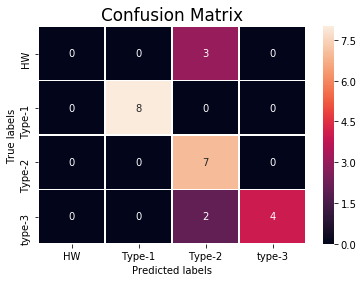

<Figure size 720x720 with 0 Axes>

In [10]:
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, ax = ax,fmt="d",linewidths=.5); #annot=True to annotate cells
sns.set(font_scale=1.4)#for label size


# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['HW','Type-1', 'Type-2', 'type-3']); ax.yaxis.set_ticklabels(['HW','Type-1', 'Type-2', 'type-3']);


## Transfer Learning - VGG

In [14]:
# extract features from each photo in the directory
#load the model, extracting features from each photo
# prepare image for VGG model, get features, Storing Features

def extract_features_vgg(X):
    in_layer = Input(shape=(224, 224, 3))
    model = VGG16(include_top=False, input_tensor=in_layer)
    features = []
    for image in X:
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        feature = model.predict(image, verbose=0)
        features.append(feature)
    return features


X_vgg_features = extract_features_vgg(X)
y_cat = tf.keras.utils.to_categorical(Y)

In [18]:
def build_model(hidden_size = 128):
    import tensorflow.keras as keras
    fnn_model = keras.Sequential()
    fnn_model.add(keras.layers.Flatten())
    fnn_model.add(keras.layers.Dense(hidden_size, activation='relu'))
    fnn_model.add(keras.layers.Dropout(0.2))
    fnn_model.add(keras.layers.Dense(4, activation='softmax'))
    fnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return fnn_model

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vgg_features, Y, test_size = 0.2,random_state = 1234)

fnn_model = build_model(hidden_size=128)
fnn_model.fit(np.array(X_vgg_features), y_cat , epochs=10, batch_size=128,verbose =0)
y_pred = fnn_model.predict(np.array(X_test))

In [16]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)
len(y_pred)

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('Classification Report')
target_names = ['HandWritten','Type 1 Block', 'Type 2 Empty', 'type 3 Lines']
print(classification_report(y_test, y_pred, target_names=target_names))


[3 1 2 2 0 1 1 3 1 0 1 3 2 2 1 3 2 2 0 2 0 1 3 3]
Confusion Matrix
[[4 0 0 0]
 [0 7 0 0]
 [0 0 7 0]
 [0 0 0 6]]
Classification Report
              precision    recall  f1-score   support

 HandWritten       1.00      1.00      1.00         4
Type 1 Block       1.00      1.00      1.00         7
Type 2 Empty       1.00      1.00      1.00         7
type 3 Lines       1.00      1.00      1.00         6

   micro avg       1.00      1.00      1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



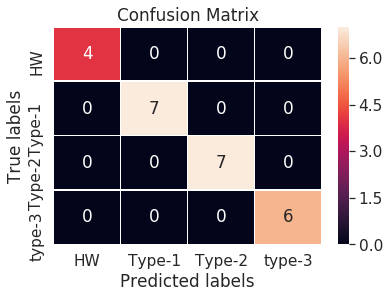

<Figure size 720x720 with 0 Axes>

In [17]:
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, ax = ax,fmt="d",linewidths=.5); #annot=True to annotate cells
sns.set(font_scale=1.4)#for label size


# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['HW','Type-1', 'Type-2', 'type-3']); ax.yaxis.set_ticklabels(['HW','Type-1', 'Type-2', 'type-3']);


In [19]:
y_pred1 = np.argmax(y_pred, axis=1)
print(y_pred1)
len(y_pred1)

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred1))
print('Classification Report')
target_names = ['HandWritten','Type 1 Block', 'Type 2 Empty', 'type 3 Lines']
print(classification_report(y_test, y_pred1, target_names=target_names))

[3 3 1 2 2 2 1 2 3 2 1 1 1 1 2 2 3 1 2 2 2 3 1 3]
Confusion Matrix
[[ 0  0  0  1]
 [ 0  8  0  0]
 [ 0  0 10  0]
 [ 0  0  0  5]]
Classification Report
              precision    recall  f1-score   support

 HandWritten       0.00      0.00      0.00         1
Type 1 Block       1.00      1.00      1.00         8
Type 2 Empty       1.00      1.00      1.00        10
type 3 Lines       0.83      1.00      0.91         5

   micro avg       0.96      0.96      0.96        24
   macro avg       0.71      0.75      0.73        24
weighted avg       0.92      0.96      0.94        24



/Users/varun/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/varun/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/varun/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


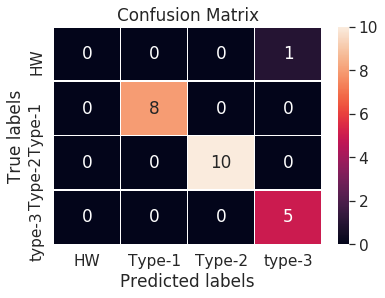

<Figure size 720x720 with 0 Axes>

In [20]:
y_pred1 = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred1)

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, ax = ax,fmt="d",linewidths=.5); #annot=True to annotate cells
sns.set(font_scale=1.4)#for label size


# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['HW','Type-1', 'Type-2', 'type-3']); ax.yaxis.set_ticklabels(['HW','Type-1', 'Type-2', 'type-3']);


In [19]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=1234)
cvscores_vgg = []
for train, test in kfold.split(X, Y):
    fnn_model = build_model(hidden_size=128)
    fnn_model.fit(np.array(X_vgg_features)[train], y_cat[train] , epochs=10, batch_size=128,verbose =0)
    score = fnn_model.evaluate(np.array(X_vgg_features)[test],y_cat[test],verbose=0)
    cvscores_vgg.append(score[1])
    
    
for i,score in enumerate(cvscores_vgg):
    print("The accuracy for {} is {:.2f}".format(i+1,score))
    
print("The average accuracy on 10-fold cross validation is {:.2f} with standard deviation {:.2f}"\
      .format(np.mean(cvscores_vgg),np.std(cvscores_vgg)))

C:\Users\swamireddy.v\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=6.
  % (min_groups, self.n_splits)), Warning)


The accuracy for 1 is 1.00
The accuracy for 2 is 0.90
The accuracy for 3 is 1.00
The accuracy for 4 is 0.95
The accuracy for 5 is 1.00
The accuracy for 6 is 1.00
The average accuracy on 10-fold cross validation is 0.98 with standard deviation 0.04


In [20]:
def extract_features_resnet(X):
# load the model
    in_layer = Input(shape=(224, 224, 3))
    model = ResNet50(include_top=False, input_tensor=in_layer)
    # extract features from each photo
    features = []
    for image in X:
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the ResNet model
        image = resnet_preprocess(image)
        # get features
        feature = model.predict(image, verbose=0)
        # store feature
        features.append(feature)
    return features

y_cat = tf.keras.utils.to_categorical(Y)


X_resnet_features = extract_features_resnet(X)
#Ref: https://www.tensorflow.org/guide/keras/overview
# build our own model
def build_model(hidden_size = 128):
    # build a feed forward NN 
    import tensorflow.keras as keras

    fnn_model = keras.Sequential()
    # Add a densely-connected layer 
    fnn_model.add(keras.layers.Flatten())
    fnn_model.add(keras.layers.Dense(hidden_size, activation='relu'))
    fnn_model.add(keras.layers.Dropout(0.2))
    # Add a softmax layer with 4 output units:
    fnn_model.add(keras.layers.Dense(4, activation='softmax'))

    fnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return fnn_model



In [21]:
cvscores_resnet = []
for train, test in kfold.split(X, Y):
    fnn_model = build_model(hidden_size=256)
    fnn_model.fit(np.array(X_resnet_features)[train], y_cat[train] , epochs=10, batch_size=32,verbose =0)
    score = fnn_model.evaluate(np.array(X_resnet_features)[test],y_cat[test],verbose=0)
    cvscores_resnet.append(score[1])
    
# print 6 fold cross validation acccuracy for Resnet50
for i,score in enumerate(cvscores_resnet):
    print("The accuracy for Resnet fold {} is {:.2f}".format(i+1,score))
    
# taking average of accuracy of k fold cv
print("The average accuracy on 6-fold cross validation for Resnet is {:.2f} with standard deviation {:.2f}"\
      .format(np.mean(cvscores_resnet),np.std(cvscores_resnet)))

C:\Users\swamireddy.v\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=6.
  % (min_groups, self.n_splits)), Warning)


The accuracy for Resnet fold 1 is 1.00
The accuracy for Resnet fold 2 is 0.95
The accuracy for Resnet fold 3 is 1.00
The accuracy for Resnet fold 4 is 0.95
The accuracy for Resnet fold 5 is 1.00
The accuracy for Resnet fold 6 is 1.00
The average accuracy on 6-fold cross validation for Resnet is 0.98 with standard deviation 0.02


In [22]:
# for type 1 Blocks
from PIL import Image, ImageOps
 
def crop(image_path, border,saved_location):
    img = Image.open(image_path)
    cropped_image = ImageOps.crop(img, border)
    cropped_image.save(saved_location)
    
if __name__ == '__main__':
    img_dir = 'E:\\Analytics\\AIapplications\\AIimages\\Type-1 blocks'
    for img_path in glob.glob(img_dir+"\\*.jpg"):
        img = img_path.split("\\")
        location = 'E:\\Analytics\\AIapplications\\AIimages\\Croppedimages\\Type-1 blocks\\'
        saved_location = location + img[-1]
        crop(img_path, (0, 0, 0, 410),saved_location)

In [23]:
# for type 2 Empty
from PIL import Image, ImageOps
 
def crop(image_path, border,saved_location):
    img = Image.open(image_path)
    cropped_image = ImageOps.crop(img, border)
    cropped_image.save(saved_location)
    
if __name__ == '__main__':
    img_dir = 'E:\\Analytics\\AIapplications\\AIimages\\Type-2 Empty'
    for img_path in glob.glob(img_dir+"\\*.jpg"):
        img = img_path.split("\\")
        location = 'E:\\Analytics\\AIapplications\\AIimages\\Croppedimages\\Type-2 Empty\\'
        saved_location = location + img[-1]
        crop(img_path, (0, 0, 100, 50),saved_location)

In [24]:
# for type 3 lines
from PIL import Image, ImageOps
 
def crop(image_path, border,saved_location):
    img = Image.open(image_path)
    cropped_image = ImageOps.crop(img, border)
    cropped_image.save(saved_location)

if __name__ == '__main__':
    img_dir = 'E:\\Analytics\\AIapplications\\AIimages\Type-3 lines'
    for img_path in glob.glob(img_dir+"\\*.jpg"):
        img = img_path.split("\\")
        location = "E:\\Analytics\\AIapplications\\AIimages\\Croppedimages\\Type-3 lines\\"
        saved_location = location + img[-1]
        crop(img_path, (0, 0, 0, 250),saved_location)

In [28]:
import os
import cv2
import sys
import pytesseract
from PIL import Image, ImageOps
import tempfile
import numpy as np
import matplotlib.pyplot as plt

IMAGE_SIZE = 1024
BINARY_THREHOLD = 180
directory = "E:\\Analytics\\AIapplications\\AIimages\\Type-1 blocks"
pytesseract.pytesseract.tesseract_cmd = r"C:\\Program Files\\Tesseract-OCR\\tesseract.exe"


def process_image_for_ocr(file_path):
    
    temp_filename = set_image_dpi(file_path)
    #im_new=remove_noise_and_smooth(temp_filename)
    return (temp_filename)

def set_image_dpi(file_path):
    im = Image.open(file_path)
    im = ImageOps.expand(im, border=16)
    length_x, width_y = im.size
    factor = min(1, int(IMAGE_SIZE / length_x))
    size = factor * length_x, factor * width_y
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.jpg')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(300, 300))
    return temp_filename

def image_smoothening(img):
    ret1, th1 = cv2.threshold(img, BINARY_THREHOLD, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

def remove_noise_and_smooth(file_name):
    img = plt.imread(file_name)
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41,3)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    plt.imshow(or_image)
    return or_image

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg"): 
        image = os.path.join(directory, filename)
        config=()
        text = pytesseract.image_to_string(process_image_for_ocr(image))
        print(text)
    else:
        continue
     

DECEDENT AGE INTERMENT NO
DABA, AYEHUSH H (FEMALE) 68 NA
DATE OF INTERMENT SECTION BLOCK LOT-TER- ROW GRICA/ NI VETERAN
3/11/2016 33 225 ROW 2 6 NO
FUNERAL HOME VAULT
GATLING GR BOX #30

LOT OWNER RELATION
NEXT OF KIN RELATION

TADESSE DABA HUSBAND
ADDRESS

7217 S MAY

CHICAGO, IL 60617 702-292-0263
MARKER SINGLE (CICOMPANION OmonuMENT "““" C)in Clout

 

mre OGRANITE 0 BRONZE/GRANITE 0 VETERAN

 

DATE SET EMAIL $4 q,
OsctaseD

DABA, LEMANEE

rT ERNE BST 08
DATE OF INTERMENT BECTON

LOT-TER on VITHRAR
6/24/96 33 233R0Wi| 6 Pe [vo
OMOUMAGATLING'S CHAPEL
GRAVE BOX #30

 

VAULT

LoTownin

 

 

NEXT OF mi

TADESSE DABA, FATHER =“
7217 S. MAY, CHGO., IL 60621
ECEASED INTERMENT WO

DABA, SHORRO

 

 

 

 

 

 

 

DATE OF INTERMENT SECTION LOT-TER an ‘age VETERAN
9/19/96 33 233R0W1 2 18 NO
URDERTARER

GATLING'S CHAPEL
GRAVE BOX #30

LOT OWNER RELATION

VAULT

 

 

WEXT OF We

TADESSE DABA, -MeeHER FATHEC
7217 §. MAY, CHICAGO, IL 60621

— BT 6. MY AEX Lradlépen Peony
San fH+G3-36/9: “



‘OTT RAME ATT BI

 

 

 

 

 

DECEASED
DAILEY, LEON NA
OATE OF ETLAMENT stcTion: eor-rga an act | witTinan
7/21/2003 | 18 125 | A 53 NO
USRDIATASER
LEAK
vault
GR_BOX #30
LOT Owner elLaATog
atanons

 

muvormin”  GERALDINE DAILEY (SISTER)
10229 S. YALE AVE.
CHICAGO, IL 60628 (773)785-1829°

REMARKS
OeceaseD art gnaeg wT 960

DAILEY, LEON JR.

 

DATE OF Te ARENT atcnon LOT-TER ak veTuRans
4/4/97 W348 "5 25 NO

 

UNDERTAKER

JOHNSON FUNERAL HOME

 

vat

GRAVE BOX #30

 

LOT Gwmen MELA ee

 

 

RELATION

serovem’ VERNA BERRYMAN (MOTHER)

 

1245 W. MORRIS, CHGO., IL 50626

 

memaned 773/381-9442
OacuasiD Teg OTTO

 

 

 

 

 

 

DAILEY, LILLI NA
pari cr sicnos aor-Taa agi vweTasan
10/26/10 "| 21 [Se ROW1 "y NA NO
UBDERTARER
TAYLOR
oma
GR BOX #30
LO) Ownmia ananos
PUBLIC GUARDIAN
auanos

ONT OF nom

 

Marker.
DIceaseD
DAILEY, MARY NA
DATE OF TERRE AT s1cnon 1ol-Tin on aa vitunan
1/12/10 [ L 50 | ae | 16 | NO
UNDE ATAKeR
W. W. HOLT
vat
BOX
LOT OWEER aLaATOS
BETTY MAYS (SISTER)
o

In [27]:
import os
import cv2
import sys
import pytesseract
from PIL import Image, ImageOps
import tempfile
import numpy as np
import matplotlib.pyplot as plt

output_dir = 'C:\\Users\\swamireddy.v\\Desktop\\outputs'

def get_string(img_path):
    img = cv2.imread(img_path)

    # Extract the file name without the file extension
    file_name = os.path.basename(img_path).split('.')[0]
    file_name = file_name.split()[0]

    # Create a directory for outputs
    output_path = os.path.join(output_dir, file_name)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    img = cv2.resize(img, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
    # Convert to gray
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply dilation and erosion to remove some noise
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    img = cv2.erode(img, kernel, iterations=1)
    # Apply blur to smooth out the edges
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # Apply threshold to get image with only b&w (binarization)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # Save the filtered image in the output directory
    save_path = os.path.join(output_path, file_name + "_filter_"  + ".jpg")
    cv2.imwrite(save_path, img)

    # Recognize text with tesseract for python
    result = pytesseract.image_to_string(img, lang="eng")
    return result

get_string('E:/Analytics/AIapplications/AIimages/Croppedimages/Type-1 blocks/iCard_021881_1_Dabney_Jermaine_Lemont.jpg')

'oaceasiD Grt fmt rt BO\n\nDABNEY, JERMAINE LEMONT\n\nOATH OF TERRE WT\n\n \n\n10/9/2003\n\nUSDSRIAGIA'